In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})

# for custom notebook formatting.
from IPython.core.display import HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
HTML(open('../custom.css').read())


<br>

## Natural Language Processing
### :::: Probabilistic Context-free grammars ::::

<br>

<br><br><br><br><br><br><br><br><br>


## Recall Context-free Grammars (CFGs)

A context-free grammar is a four-tuple $G = (N, \Sigma, P, S)$:

1. A set of non-terminal symbols (or 'variables') $N$
2. A set of terminal symbols $\Sigma$ (disjoint from $N$)
3. A set of productions $P$ of the form $A \rightarrow \alpha$, where
 - $A \in N$ is a non-terminal
 - $\alpha$ is a string of symbols from the infinite set $(\Sigma \cup N)^*$
4. A start symbol $S$


A string $\alpha_1$ **derives** a string $\alpha_m$ if $\alpha_1$ can be rewritten as $\alpha_m$ by a series of rule applications from $P$.

$$\alpha_1 \Rightarrow \alpha_2,  \alpha_2 \Rightarrow \alpha_3,  \ldots,  \alpha_{m-1} \Rightarrow \alpha_m$$  

Denoted: $\alpha_1 \Rightarrow^* \alpha_m$

If $A \rightarrow \beta$ is a production in $P$, and $\alpha$ and $\gamma$ are strings in $(\Sigma \cup N)^*$,
- $\alpha A \gamma$ **directly derives** $\alpha \beta \gamma$
- denoted: $\alpha A \gamma \Rightarrow \alpha \beta \gamma$

> a $Noun$ ride $\Rightarrow$ a train ride (by applying $Noun \rightarrow train$)


![figs/lexicon.png](figs/lexicon.png)

![figs/grammar.png](figs/grammar.png)

![figs/flight.png](figs/flight.png)


<br><br>

## Probabilistic CFGs

Each rule in $P$ is augmented with a conditional probability:

$$ A \rightarrow \beta  [p] $$

where $p \triangleq p(A \rightarrow \beta \mid A)$  
Probability that nonterminal $A$ is expanded into $\beta$  
Probabilities of all expansions of $A$ must sum to 1.

So, a PCFG is a five-tuple $G = (N, \Sigma, P, S, D)$  
where the additional term $D: P \mapsto \mathbb{R}$ assigns probabilities to each rule in $P$

![pcfg1](figs/pcfg1.png)


### Why PCFGs? Resolving ambiguity

![ambig](figs/ambig.png)

## Probability of a parse

$$ p(T, S) = \prod_{n \in T} p(r(n)) $$
- $T$ is a parse
- $S$ is a sentence
- $r(n)$ is one rule used to expand node $n$ in the parse tree
- Probability of a parse is the product of the probabilities of each rule in that parse.

Note that 
$$p(T, S) = p(T)p(S|T) = p(T) $$
since $p(S|T) == 1$. 

E.g., probability of $[S \rightarrow$ Aux NP VP $ \wedge $ Aux $\rightarrow$ can] = .15 * .40

<br><br><br>

By decomposing the probability into a product of production probabilities, what assumptions have we made?

Recall independence assumption $p(A,B) \triangleq p(A) p(B)$

- Each production is independent of all other productions
  - E.g., Seeing S $\rightarrow $NP VP has no impact on NP $\rightarrow$ Det N
- Insensitive to lexical information (words)
  - E.g., Seeing NP $\rightarrow$ Det N is the same whether the noun is "cat" or "people"


<br><br>

## Probability of a sentence

$$p(S) = \sum_{T \in \tau(S)} p(T, S) = \sum_{T \in \tau(S)} p(T) $$
- $\tau(S)$ is set of all valid parse trees of sentence S
- Probability of a sentence is the sum of the probabilities of all valid parses of that sentence.

<br><br>

Recall the fluency component of translation models:
For a source sentence $A$, find the best target sentence $B$ by:

$$T^* \leftarrow \mathrm{argmax}_{\: B} \: P(B) P(A \mid B)$$

- $P(B)$: "fluency". How likely is this sentence $B$ overall? <-- **Can use sentence probability above!**
- $P(A \mid B):$  "faithfulness". How closely does the meaning of $B$ match that of $A$?

<br><br>

## Parsing with PCFGs

For a given sentence, we often want to know the highest probability parse:

$$
T^* = \mathrm{argmax}_{T \in \tau(S)} p(T)
$$



<br><br><br>

## CKY Parsing
 Cocke-Younger-Kasami algorithm for finding the most likely parse of a sentence:
 
$$
T^* = \mathrm{argmax}_{T \in \tau(S)} p(T)
$$

- Analogous to the Viterbi algorithm for HMMs, but here extend to parse trees instead of sequences.
- CKY is a bottom-up parser using dynamic programming to store intermediate results (for subtrees)
- Assumes rules are in **Chomsky Normal Form (CNF)**
 - Each production is either A $\rightarrow$ B C or A $\rightarrow a$.
 - Any CFG can be converted to CNF (though may expand grammar quadratically)


<br><br><br>

## CKY Parsing

**Input**
- A grammar $G$ in CNF
  - $|N|$ nonterminals indexed by $1 \ldots |N|$
  - Start symbol $S$ has index 1

**Dynamic Programming Table**
- 3d array $\pi[i, j, X]$ storing the maximum probability for a constituent with nonterminal index $X$ spanning words $i \ldots j$.

![cky](figs/cky.png)

**Output**
The maximum probability parse, stored in $\pi[1, n, S]$
  - $S$ spans words 1 to $n$, the length of the sentence.

## CKY Parsing

Let $w_{ij}$ indicate the string of words $\{w_i \ldots w_j\}$

The recursive definition is:

##### base case:
For a single word $w_i$, we can use the probability $X \rightarrow w_i$ for all $X$ that can produce $w_i$

$$\pi[i,i,X] = p(X \rightarrow w_i)$$

$\pi[i,i,X]=0$ if there is no rule $X \rightarrow w_i$

##### recursive case:

for multiple words, $A \Rightarrow^*w_{ij}$ if and only if
  - There is some rule $A \rightarrow$ B C
  - There is some $k$ s.t. $1 \le k \le j$ such that
    - B derives the first $k$ symbols of $w_{ij}$ and
    - C derives the last $j-k$ symbols of $w_{ij}$
    - The $k$ value is the **split point** -- determines which words are derived from $B$ and which are derived from $C$

<br>

  - The maximum probability of these shorter strings will already be in matrix $\pi$
  - So, we can multiply the probabilities of these shorter strings.
  - Since there are many ways of splitting this long string into shorter ones, we take the max over all $k$ and all rules
  
$$
\pi[i,j,X] = \max_{X \rightarrow Y Z\\ k \in \{i \ldots j-1\}} \Big(p(X \rightarrow Y Z) \times \pi(i, k, Y) \times \pi(k+1, j, Z) \Big)
$$

> The highest probability parse for words $w_i \ldots w_j$ using symbol $X$ is the maximum of all possible expansions of $X$ that span $w_i \ldots w_j$

<br><br><br>

![ckyalg](figs/ckyalg.png)
  
  
<br>

**Runtime??**
- assume $n$ words in sentence and $N$ nonterminals.

<br><br><br><br>


<br><br>

$$O(n^3 N^3)$$
 
 
at least it's not exponential!

## CKY example

Consider this PCFG in Chomsky Normal Form:

![rules](figs/rules2.png)

![lexi2](figs/lexi2.png)

$$
\begin{align}
\pi[2,3,NP] &=& \max_{\mathrm{NP} \rightarrow Y Z\\ k \in \{2 \ldots 2\}} \Big(p(\mathrm{NP} \rightarrow Y Z) \times \pi(2, k, Y) \times \pi(k+1, 3, Z) \Big)\\
&=& p(\mathrm{NP} \rightarrow \mathrm{Det} ~~ \mathrm{Nominal}) \times \pi[2,2, \mathrm{Det}] \times \pi [3,3, \mathrm{Nominal}]\\
&=& .6 \times .6 \times .15 = .054
\end{align}
$$

![s1](figs/s1.png)

$$
\begin{align}
\pi[1,3,VP] &=& \max_{\mathrm{VP} \rightarrow Y Z\\ k \in \{1 \ldots 2\}} \Big(p(\mathrm{VP} \rightarrow Y Z) \times \pi(1, k, Y) \times \pi(k+1, 3, Z) \Big)\\
&=& \max [~~ p(\mathrm{VP} \rightarrow \mathrm{Verb} ~~ \mathrm{NP}) \times \pi[1,1, \mathrm{Verb}] \times \pi [2,3, \mathrm{NP}],\\
&& p(\mathrm{VP} \rightarrow \mathrm{VP} ~~ \mathrm{PP}) \times \pi[1,1, \mathrm{VP}] \times \pi [2,3, \mathrm{PP}]]\\
&=& .5 \times .5 \times .054 = .0135
\end{align}
$$

![s1](figs/s2.png)

![s1](figs/s3.png)

![s1](figs/s4.png)

![s1](figs/s5.png)

In [15]:
# nltk supports PCFGs

import nltk
grammar = nltk.PCFG.fromstring("""
    S    -> NP VP              [1.0]
    VP   -> TV NP              [0.4]
    VP   -> IV                 [0.3]
    VP   -> DatV NP NP         [0.3]
    TV   -> 'saw'              [1.0]
    IV   -> 'ate'              [1.0]
    DatV -> 'gave'             [1.0]
    NP   -> 'telescopes'       [0.8]
    NP   -> 'Jack'             [0.1]
    NP   -> 'Jane'             [0.1]
    """)

print(grammar)

Grammar with 10 productions (start state = S)
    S -> NP VP [1.0]
    VP -> TV NP [0.4]
    VP -> IV [0.3]
    VP -> DatV NP NP [0.3]
    TV -> 'saw' [1.0]
    IV -> 'ate' [1.0]
    DatV -> 'gave' [1.0]
    NP -> 'telescopes' [0.8]
    NP -> 'Jack' [0.1]
    NP -> 'Jane' [0.1]


In [16]:
viterbi_parser = nltk.ViterbiParser(grammar)
for tree in viterbi_parser.parse(['Jack', 'saw', 'telescopes']):
    print(tree)

(S (NP Jack) (VP (TV saw) (NP telescopes))) (p=0.032)


<br><br><br>

## How to estimate PCFG probabilities?

**Treebank**: Collection of sentences with human-annotated parse trees


$$ p(\alpha \rightarrow \beta \mid \alpha) = \frac{C(\alpha \rightarrow \beta)}{\sum_\gamma C(\alpha \rightarrow \gamma)} $$

- $C(\alpha \rightarrow \beta)$: The number of times constituent $\alpha$ was expanded to list of constituents $\beta$ 
- Smoothing is again important here 


<br><br>
There is also an unsupervised version (analogous to Forward-Backward algorithm for HMMs), but they don't tend to perform well without further constraints.



In [17]:
# nltk provides a sample treebank dataset.
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/culotta/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [18]:
from nltk.corpus import treebank
treebank.fileids()

['wsj_0001.mrg',
 'wsj_0002.mrg',
 'wsj_0003.mrg',
 'wsj_0004.mrg',
 'wsj_0005.mrg',
 'wsj_0006.mrg',
 'wsj_0007.mrg',
 'wsj_0008.mrg',
 'wsj_0009.mrg',
 'wsj_0010.mrg',
 'wsj_0011.mrg',
 'wsj_0012.mrg',
 'wsj_0013.mrg',
 'wsj_0014.mrg',
 'wsj_0015.mrg',
 'wsj_0016.mrg',
 'wsj_0017.mrg',
 'wsj_0018.mrg',
 'wsj_0019.mrg',
 'wsj_0020.mrg',
 'wsj_0021.mrg',
 'wsj_0022.mrg',
 'wsj_0023.mrg',
 'wsj_0024.mrg',
 'wsj_0025.mrg',
 'wsj_0026.mrg',
 'wsj_0027.mrg',
 'wsj_0028.mrg',
 'wsj_0029.mrg',
 'wsj_0030.mrg',
 'wsj_0031.mrg',
 'wsj_0032.mrg',
 'wsj_0033.mrg',
 'wsj_0034.mrg',
 'wsj_0035.mrg',
 'wsj_0036.mrg',
 'wsj_0037.mrg',
 'wsj_0038.mrg',
 'wsj_0039.mrg',
 'wsj_0040.mrg',
 'wsj_0041.mrg',
 'wsj_0042.mrg',
 'wsj_0043.mrg',
 'wsj_0044.mrg',
 'wsj_0045.mrg',
 'wsj_0046.mrg',
 'wsj_0047.mrg',
 'wsj_0048.mrg',
 'wsj_0049.mrg',
 'wsj_0050.mrg',
 'wsj_0051.mrg',
 'wsj_0052.mrg',
 'wsj_0053.mrg',
 'wsj_0054.mrg',
 'wsj_0055.mrg',
 'wsj_0056.mrg',
 'wsj_0057.mrg',
 'wsj_0058.mrg',
 'wsj_0059.mrg

['A', 'form', 'of', 'asbestos', 'once', 'used', '*', '*', 'to', 'make', 'Kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', '*', 'to', 'it', 'more', 'than', '30', 'years', 'ago', ',', 'researchers', 'reported']




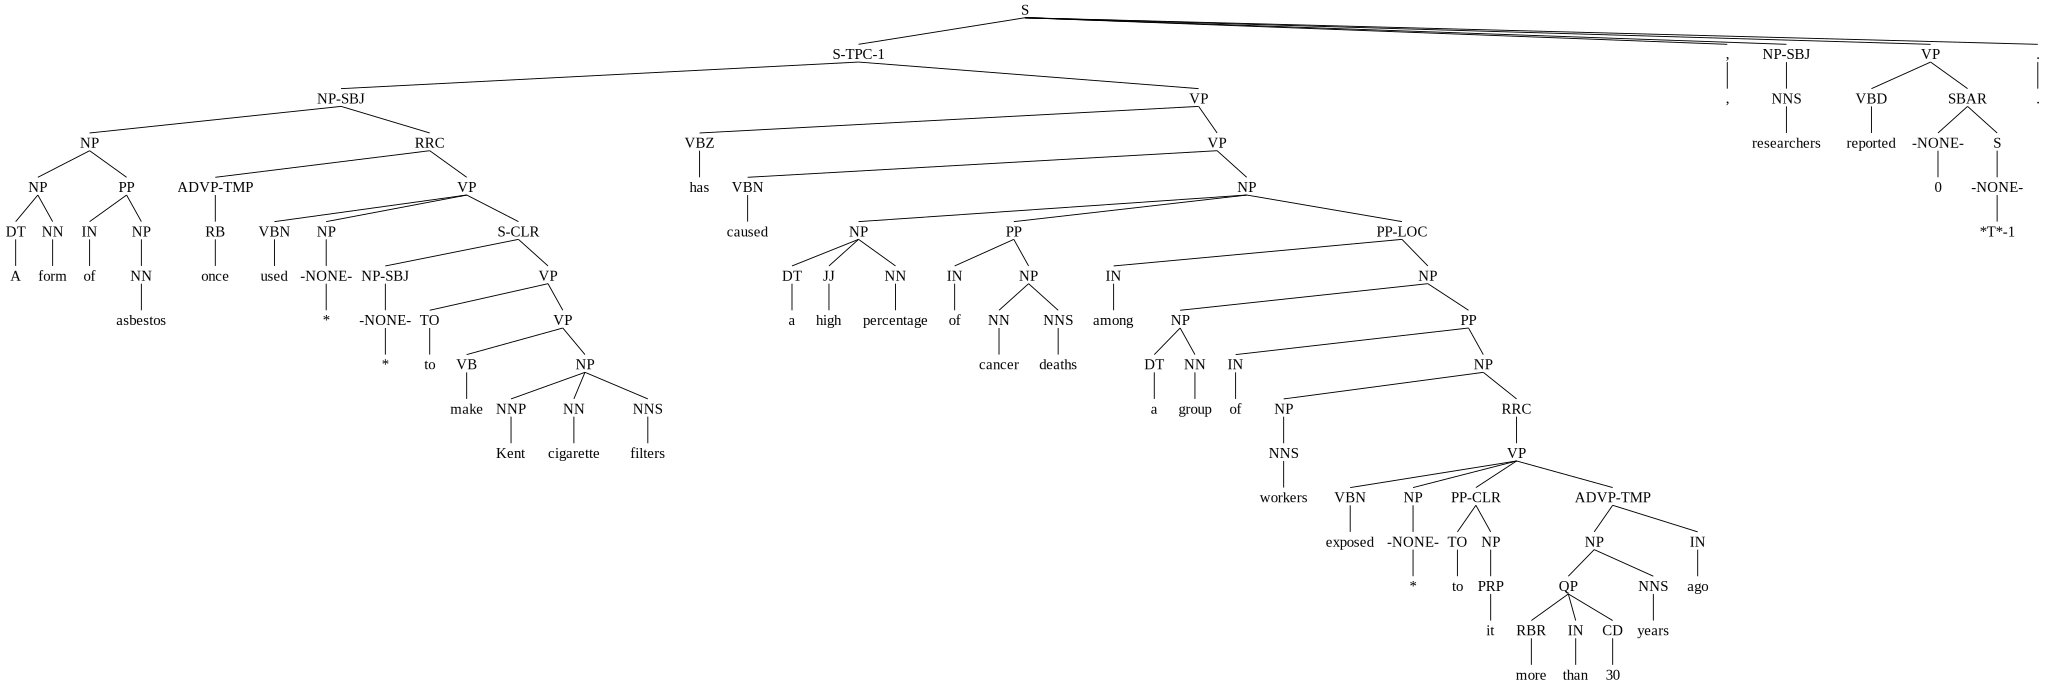

(S
  (S-TPC-1
    (NP-SBJ
      (NP (NP (DT A) (NN form)) (PP (IN of) (NP (NN asbestos))))
      (RRC
        (ADVP-TMP (RB once))
        (VP
          (VBN used)
          (NP (-NONE- *))
          (S-CLR
            (NP-SBJ (-NONE- *))
            (VP
              (TO to)
              (VP
                (VB make)
                (NP (NNP Kent) (NN cigarette) (NNS filters))))))))
    (VP
      (VBZ has)
      (VP
        (VBN caused)
        (NP
          (NP (DT a) (JJ high) (NN percentage))
          (PP (IN of) (NP (NN cancer) (NNS deaths)))
          (PP-LOC
            (IN among)
            (NP
              (NP (DT a) (NN group))
              (PP
                (IN of)
                (NP
                  (NP (NNS workers))
                  (RRC
                    (VP
                      (VBN exposed)
                      (NP (-NONE- *))
                      (PP-CLR (TO to) (NP (PRP it)))
                      (ADVP-TMP
                        (NP
                 

In [19]:
print(treebank.words('wsj_0003.mrg')[:38])
print('\n')
display(treebank.parsed_sents('wsj_0003.mrg')[0])
print(treebank.parsed_sents('wsj_0003.mrg')[0]) 

<br><br>

## Assumptions of PCFGs

- Non-terminal rules do not depend on terminals
  - E.g., $p($VP $\rightarrow$ V NP NP$)$ is same *no matter what the verb is!*
  - But, "give him the ball" is more likely than "fly him the kite" (*ditransitive* verbs)

![lexi](figs/lexi.png)

## Lexicalized PCFGs

**Idea:** Store the **headword** of each constituent
  - the central sub-constituent of each rule

There are rules to determine the head word from a parse tree:

![head](figs/head.png)

<br><br>

![lex](figs/lex.png)


Like a PCFG, but with many more rules
- one copy for each headword

E.g.

VP(dumped) $\rightarrow$ VBD(dumped) NP(sacks) PP(into) [3e-10]

But, these events are too rare for us to estimate their probabilities from labeled data.

<br><br><br>
To scale, we will condition on the head node $h(n)$


Recall that normal PCFG estimates $p(r(n) \mid n)$
  - the probability of node $n$ being expanded by rule $r(n)$
  
##### Lexicalized version: 
$$ p(r(n) \mid n, h(n))$$
- $h(n)$ is head of $n$


E.g., probability of VP $\rightarrow$ VBD NP PP in earlier example is   
- $p(r \mid $ VP, dumped$)$
  - What is probability that a VP headed by "dumped" will expand to VBD NP PP?
  
<br><br> What about the probability of a head? We model the probability that the head of node $n$ is $w_i$ as

$$p(h(n) = w_i \mid n, h(m(n))$$
- $m(n)$ is the parent of $n$

e.g.

$p(h(n) = \mathrm{sacks} \mid n=NP, h(m(n)) = \mathrm{dumped})$
- What's the probability that an NP whose parent's head is "dumped" has the head "sacks"
- This is kind of like an $n$gram model, but using parse tree to find "previous" terms
  - "previous" here means an ancestor in the tree
  
<br><br>
Finally, we compute the probability of a lexicalized parse as:

$$
p(T, S) = \prod_{n \in T} p(r(n) \mid n, h(n)) \times p(h(n) \mid n, h(m(n)))
$$

As before, we can estimate the probabilities $p(r(n) \mid n, h(n))$  and $p(h(n) \mid n, h(m(n)))$ from treebank.
- smoothing even more important, due to low frequency of events.

Using lexicalized PCFG we should be able to correctly attach the PP in the example:

##### Incorrect:

![lexwrong](figs/lexwrong.png)

##### Correct:

![lex](figs/lex.png)



$p($ VP $\rightarrow$ VBD NP PP $ \mid VP$, dumped $) ~~ > ~~ p($ VP $\rightarrow$ VBD NP $ \mid VP$, dumped $)$

### image sources
- <https://www.cs.colorado.edu/~martin/SLP/>
- <https://people.cs.umass.edu/~mccallum/courses/inlp2007/lect13-probparsing.key.pdf>
- <https://nitishkr.wordpress.com/2011/03/29/cyk-algorithm-implementation/>
- <https://www.cs.utexas.edu/~mooney/cs388/>

In [1]:
from IPython.core.display import HTML
HTML(open('../custom.css').read())